# Step 4.
#### Main attack loop: for each model for each task
* Get task metadata, embeddings, trained MLP models
* Evaluate models on clean embeddings (with my pipeline)
* Wrap in ART model
* Attack with Boundary and HopSkipJump attacks
* Evaluate models on adversarial embeddings

**attackPipeline (attackHyb) Env**

#### Functions of main loop

In [1]:
# Libraries
import json
import os
import sys
import pickle
import numpy as np
import torch
from art.estimators.classification import PyTorchClassifier
import csv
import time

/home/paolo/.conda/envs/attackHyb/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# GPU Settings
# Check if GPU is available
if torch.cuda.is_available():
    # Get the index of the current CUDA device
    current_device_index = torch.cuda.current_device()
    
    # Create a torch.device object for the current device
    current_device = torch.device(f'cuda:{current_device_index}')

    # Get current device name
    current_device_name = torch.cuda.get_device_name(0)
    
    print(f"Current CUDA Device Index: {current_device_index}")
    print(f"Current CUDA Device: {current_device}")
    print(f"Current CUDA Device: {current_device_name}")
else:
    print("CUDA is not available.")

Current CUDA Device Index: 0
Current CUDA Device: cuda:0
Current CUDA Device: NVIDIA TITAN V


In [3]:
def get_embeddings(
    embeddings_path: str,
    split: str,
    n_folds: int = None
):
    """ Return the embeddings for the given embeddings path.
    
    Parameters
    ------------------------
    embeddings_path: str
        The embeddings path
    split: str
        The kind of split used (TVT, folds)
    n_folds: int = None
        The number of folds if split="folds" (optional)
        
    Returns
    ------------------------
    embeddings: dict[list[np.ndarray[np.float32]]. Array shape: (embedding_dim,)
        The dict with the embeddings organized per splits."""

    if split == "TVT":
        embeddings = {}
        embeddings["test"] = []
        
        embeddings_files_path = f"{embeddings_path}/test"
        for file in sorted(os.listdir(embeddings_files_path)):
            if file.endswith(".npy"):
                embedding_path = os.path.join(embeddings_files_path, file)
                embedding = np.load(embedding_path)
                embeddings["test"].append(embedding)

        print(f"stored test embeddings {embeddings_files_path}")

        return embeddings

    elif split == "folds":
        embeddings = {}
        
        for fold in range(n_folds):
            embeddings[f"fold0{fold}"] = []
            
            embeddings_files_path = f"{embeddings_path}/fold0{fold}"
            for file in sorted(os.listdir(embeddings_files_path)):
                if file.endswith(".npy"):
                    embedding_path = os.path.join(embeddings_files_path, file)
                    embedding = np.load(embedding_path)
                    embeddings[f"fold0{fold}"].append(embedding)
                    
            print(f"stored in fold0{fold} embeddings {embeddings_files_path}")

        return embeddings

In [4]:
def get_models(
    models_path: str,
    split: str,
    n_folds: int = None
):
    """ Return the models for the given models path.
    
    Parameters
    ------------------------
    models_path: str
        The models path
    split: str
        The kind of split used (TVT, folds)
    n_folds: int = None
        The number of folds if split="folds" (optional)
        
    Returns
    ------------------------
    models: dict
        The dict with the models in eval mode organized per splits."""

    if split == "TVT":
        models = {}
        models["test"] = []

        for file in os.listdir(models_path):
            if file.endswith(".pt"):
                model_path = os.path.join(models_path, file)
                model = torch.load(model_path)
                model.eval()
                models["test"].append(model)
                print(f"stored test model {model_path} in training mode: {model.training}")
                
        return models

    elif split == "folds":
        models = {}

        for fold in range(n_folds):
            for file in os.listdir(models_path):
                if f"fold0{fold}" in file and file.endswith(".pt"):
                    models[f"fold0{fold}"] = []
                    model_path = os.path.join(models_path, file)
                    model = torch.load(model_path)
                    models[f"fold0{fold}"].append(model)
                    print(f"stored in fold0{fold} model {model_path} in training mode: {model.training}")

        return models

In [5]:
def max_one_hot(tensor):
    """ Return the prediction tensor in one-hot format (1 for the maximum value index and 0 elsewhere)."""
    max_indices = torch.argmax(tensor, dim=1)

    # One-hot tensor based on the maximum indices
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[range(tensor.shape[0]), max_indices] = 1

    return one_hot_tensor

In [6]:
def get_predictions(
    models: dict,
    data: dict
):
    """ Return the model predictions for the given test split,  
    if split="test" the single model is tested on the test split,  
    if split="folds" the models are tested on the test fold not used for training.
    
    Parameters
    ------------------------
    models: dict
        The dict of models
    data: dict[List[np.ndarray[np.float32]]
        The dict of the test data splits
        
    Returns
    ------------------------
    predictions: dict[list[torch.Tensor[torch.Tensor]]]. First tensor shape (n_samples, n_labels)
        The dict with the predictions organized per splits."""

    if (len(models) != len(data)):
        print(f"Error in function: {sys._getframe().f_code.co_name}", file=sys.stderr)
        sys.exit(f"The number of models and test data splits must be equal. Got {len(models)} and {len(data)}.")

    predictions = {}

    for split in data:
        predictions[split] = []
        model = models[split][0]
        embeddings = data[split]
        
        # Conver to tensor and stack
        tensor_embeddings = torch.stack([torch.tensor(emb) for emb in embeddings]) #(emb, device=current_device)
        
        with torch.no_grad():
            predictions[split].append(max_one_hot(model(tensor_embeddings)))
        print(f"stored predictions for split {split}")

    return predictions

In [7]:
# Change for adv predictions, device=GPU
def get_adv_predictions(
    models: dict,
    data: dict
):
    """ Return the model predictions for the given test split of adversarial data,  
    if split="test" the single model is tested on the test split,  
    if split="folds" the models are tested on the test fold not used for training.
    
    Parameters
    ------------------------
    models: dict
        The dict of models
    data: dict[List[np.ndarray[np.float32]]
        The dict of the test adversarial data splits
        
    Returns
    ------------------------
    predictions: dict[list[torch.Tensor[torch.Tensor]]]. First tensor shape (n_samples, n_labels)
        The dict with the predictions organized per splits."""

    if (len(models) != len(data)):
        print(f"Error in function: {sys._getframe().f_code.co_name}", file=sys.stderr)
        sys.exit(f"The number of models and test data splits must be equal. Got {len(models)} and {len(data)}.")

    predictions = {}

    for split in data:
        predictions[split] = []
        model = models[split][0]
        embeddings = data[split]
        
        # Conver to tensor and stack
        tensor_embeddings = torch.stack([torch.tensor(emb, device=current_device) for emb in embeddings])

        with torch.no_grad():
            predictions[split].append(max_one_hot(model(tensor_embeddings)))
        print(f"stored predictions for split {split}")

    return predictions

In [8]:
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder

def get_labels(
    embeddings_path: str,
    split: str,
    n_folds: int = None
):
    """ Return the one-hot encoded labels for the given task.
    
    Parameters
    ------------------------
    embeddings_path: str
        The embeddings path
    split: str
        The kind of split used (TVT, folds)
    n_folds: int = None
        The number of folds if split="folds" (optional)
        
    Returns
    ------------------------
    labels: dict[list[np.ndarray[np.ndarray]]]. First array shape (n_samples, n_labels)
        The dict with the one-hot encoded labels organized per splits."""
    
    if split == "TVT":
        labels = {}
        labels["test"] = []
        
        labels_path = f"{embeddings_path}/test.json"
        with open(labels_path, 'r') as file:
            labels_json = json.load(file)
    
        labels_value = []
        for l in labels_json:
            labels_value.append(labels_json[l][0])

        # One-hot encode
        label_encoder = OneHotEncoder(sparse=False)
        labels_encoded = label_encoder.fit_transform(np.array(labels_value).reshape(-1, 1))
        labels["test"].append(labels_encoded)
        print(f"stored test labels {labels_path}")
            
        return labels
        
    elif split == "folds":
        labels = {}
        for fold in range(n_folds):
            labels[f"fold0{fold}"] = []
            
            labels_path = f"{embeddings_path}/fold0{fold}.json"
            with open(labels_path, 'r') as file:
                labels_json = json.load(file)
    
            labels_value = []
            for l in labels_json:
                labels_value.append(labels_json[l][0])

            # One-hot encode
            label_encoder = OneHotEncoder(sparse=False)
            labels_encoded = label_encoder.fit_transform(np.array(labels_value).reshape(-1, 1))
            labels[f"fold0{fold}"].append(labels_encoded)
            print(f"stored in fold0{fold} labels {labels_path}")
                    
        return labels

In [9]:
from torcheval.metrics import MulticlassAccuracy

def get_metrics(
    labels: dict,
    predictions: dict,
):
    """ Return the evaluation metrics (Accuracy) for the given true labels and predictions.
    
    Parameters
    ------------------------
    labels: dict
        The true labels
    predictions: dict
        The model predictions
        
    Returns
    ------------------------
    metrics: dict[list[torch.Tensor]]
        The dict with the metrics organized per splits."""

    if len(labels) != len(predictions):
        print(f"Error in function: {sys._getframe().f_code.co_name}", file=sys.stderr)
        sys.exit(f"The number of labels splits and predictions splits must be equal. Got {len(labels)} and {len(predictions)}.")

    metrics = {}
    for split in labels:
        metrics[split] = []
        input = predictions[split][0]
        target = torch.argmax(torch.tensor(labels[split][0]), dim=1)
        
        metric = MulticlassAccuracy()
        metric.update(input, target)
        
        metrics[split].append(metric.compute())
        print(f"Added metric {metric.compute():.5f} to split {split}")
        
    return metrics

In [10]:
def get_ART_models(
    models: dict,
    input_shape: int,
    clip_values: tuple,
    n_classes: int
):
    """ Return the hear models wrapped in the ART PyTorchClassifier for the attacks.
    
    Parameters
    ------------------------
    models: dict
        The torch models
    input_shape: int
        The input shape (embedding dimension)
    clip_values: tuple
        The (min, max) of the embedding values
    n_classes: int
        The number of classes for the current task

    Returns
    ------------------------
    ART_models: dict
        The dict with the ART models organized per splits."""

    ART_models = {}
    for split in models:
        ART_models[split] = []

        # min and max embedding values *1.1 to allow some modifications outside the (min,max) range
        if clip_values[0] < 0:
            min = clip_values[0]*1.1
        else:
            min = clip_values[0]*0.9

        if clip_values[1] > 0:
            max = clip_values[1]*1.1
        else:
            max = clip_values[1]*0.9

        classifier_art = PyTorchClassifier(
            model=models[split][0],
            loss=torch.nn.CrossEntropyLoss(),
            input_shape=[input_shape],  #embeddings shape
            nb_classes=n_classes,  #of the current task
            clip_values=(min, max) 
        )
        ART_models[split].append(classifier_art)
        print(f"Wrapped {type(classifier_art)} for split {split}")

    return ART_models

In [11]:
def euclidean_distance_normalized(x, y):
    """ Computes a distance metric as the ratio of the Euclidean distance between numpy vectors x and y to their average magnitude.
        This should provide a measure of how far apart the vectors are relative to their average magnitude."""
    
    euclidean_distance = np.linalg.norm(x - y)
    magnitude_mean = np.mean([np.linalg.norm(x), np.linalg.norm(y)])
    norm_euclidean_distance = euclidean_distance / magnitude_mean
    return norm_euclidean_distance

In [12]:
from scipy.stats import ranksums

def get_distance_metrics(
    clean_embeddings: dict,
    adv_embeddings: dict,
):
    """ Return the distance metrics (Wilcoxon test p_value, Euclidean distance normalized by mean magnitude)
    of adversarial embeddings with respect to clean embeddings.
    The Wilcoxon rank-sum test tests the null hypothesis that two sets of measurements are drawn from the same distribution.
    
    Parameters
    ------------------------
    clean_embeddings: dict
        The clean embeddings organized per split
    adv_embeddings: dict
        The adversarial embeddings organized per split
  
    Returns
    ------------------------
    distance_metrics: dict
        The dict with the average distance metrics over the splits."""

    if len(clean_embeddings) != len(adv_embeddings):
        print(f"Error in function: {sys._getframe().f_code.co_name}", file=sys.stderr)
        sys.exit(f"The number of clean embeddings splits and adversarial embedding splits must be equal. Got {len(clean_embeddings)} and {len(adv_embeddings)}.")

    wilcoxon = []
    euclidean = []
    for split in clean_embeddings:
        # Perform Wilcoxon test
        _, wilcoxon_p_value = ranksums(clean_embeddings[split], adv_embeddings[split])
        wilcoxon.append(np.mean(wilcoxon_p_value))
        
        # Compute normalized euclidean distance
        euclidean_normalized = euclidean_distance_normalized(np.array(clean_embeddings[split]), np.array(adv_embeddings[split]))
        euclidean.append(np.mean(euclidean_normalized))
    
    distance_metrics = {}
    distance_metrics["Wilcoxon"] = np.mean(wilcoxon)
    distance_metrics["Euclidean"] = np.mean(euclidean)
    
    return distance_metrics

In [13]:
from art.attacks.evasion import BoundaryAttack

def get_boundary_attack(
    ART_model
):
    """ Return the boundary attack instance for the given ART model.
    
    Parameters
    ------------------------
    ART_model: art.estimators.classification.pytorch.PyTorchClassifier
        The ART model to attack
  
    Returns
    ------------------------
    boundary_attack: art.attacks.evasion.boundary.BoundaryAttack
        The boundary attack instance for the given ART model."""
    
    boundary_attack = BoundaryAttack(
        estimator=ART_model,
        targeted=False,
        batch_size = 64,
        max_iter=140,    #Maximum number of iterations
        num_trial=10,    #Maximum number of trials per iterations
        sample_size=10,  #Number of samples per trial
        step_adapt=0.7,  #Factor by which the step sizes are multiplied or divided
        verbose=False,
    )

    return boundary_attack

In [14]:
from art.attacks.evasion import HopSkipJump

def get_hopSkipJump_attack(
    ART_model
):
    """ Return the hop skip jump attack instance for the given ART model.
    
    Parameters
    ------------------------
    ART_model: art.estimators.classification.pytorch.PyTorchClassifier
        The ART model to attack
  
    Returns
    ------------------------
    hopSkipJump_attack: art.attacks.evasion.HopSkipJump
        The hop skip jump attack instance for the given ART model."""
    
    hopSkipJump_attack = HopSkipJump(
        classifier=ART_model,
        batch_size = 64,
        norm=np.inf,   #Order of the norm
        max_iter=5,    #Maximum number of iterations
        max_eval=5000, #Maximum number of evaluations for estimating gradient
        init_eval=100, #Initial number of evaluations for estimating gradient
        init_size=100, #Maximum number of trials for initial generation of adversarial examples
        targeted=False,
        verbose=True,
    )

    return hopSkipJump_attack

In [15]:
def attack(
    ART_models: dict,
    data: dict,
    attack_type: str
):
    """ Perform the adversarial attack of the given type on the ART_models.
    
    Parameters
    ------------------------
    ART_models: dict
        The ART models to attack
    data: dict[List[np.ndarray[np.float32]]
        The dict of the test data splits
    attack_type: str
        The type of attack to perform
        
    Returns
    ------------------------
    adv_data: dict
        The dict with the adversarial data organized per splits."""

    if (len(ART_models) != len(data)):
        print(f"Error in function: {sys._getframe().f_code.co_name}", file=sys.stderr)
        sys.exit(f"The number of ART models and test data splits must be equal. Got {len(ART_models)} and {len(data)}.")

    
    adv_data = {}
    for split in ART_models:
        adv_data[split] = []
        ART_model = ART_models[split][0]
        
        if attack_type == "Boundary":
            attack = get_boundary_attack(ART_model)
        elif attack_type == "HopSkipJump":
            attack = get_hopSkipJump_attack(ART_model)

        embeddings = np.array(data[split])
        
        start = time.time()
        adv_embeddings = attack.generate(x=embeddings)   
        elapsed = time.time() - start

        for adv_sample in adv_embeddings:
            adv_data[split].append(adv_sample)
            
        print(f"Generated adversarial data with {attack_type} attack for split {split} in {elapsed:.0f} sec")

    return adv_data

### Main Loop
After previous steps, expects:  
* Tasks imports
* Embeddings generated and evaluated
* MLP models saved  

Stores the results in *results* and adversarial computations in *adversarial_computations* folders

In [ ]:
## Notes:
# Distance metrics averages only is retained since x fold is close to average and irrelevant.
# All the considered tasks use accuracy as main score.
# The MLP follows the same architecture for each model/task, just with different hyperparameters  [Seq(linear,batchNorm,Dropout,Relu) x layers -> linear,softmax, with crossEntropyLoss]
# min/max embedding values for attacks: considering (min*1.1, max*1.1) to allow perturbations to change emb values even slightly outside the min/max range.

# Pickle saves clean and adv results, distance metrics, as well as adversarial embeddings and models' predictions on adversarial embeddings (hard to recompute/critical).
# Output is cut, results are displayed after.


# Get tasks, model, attacks names for the loop
with open('datasets.json', 'r') as file:
    datasets = json.load(file)
tasks_name = []
for task in datasets:
    tasks_name.append(task["name"])

models_name = ["efficient_latent", "GURA.fusion_hubert_xlarge", "GURA.fusion_wav2vec2", "GURA.fusion_cat_xwc", "GURA.avg_xwc", "hear21passt.base", "hearbaseline.wav2vec2", "audio_dbert", "panns_hear"]
attack_types = ["Boundary", "HopSkipJump"]


for model_name in models_name:
    for task_name in tasks_name:
        print(f"\n---- MAIN LOOP for {model_name} on task {task_name} ----")
        # Get task metadata
        embeddings_path = f"embeddings/{model_name}/{task_name}"
        metadata_path = f"{embeddings_path}/task_metadata.json"
        
        with open(metadata_path, 'r') as file:
            metadata = json.load(file)

        if metadata["split_mode"] == "new_split_kfold" or metadata["split_mode"] == "presplit_kfold":
            split = "folds"
            n_folds = metadata["nfolds"]
        elif metadata["split_mode"] == "trainvaltest":
            split = "TVT"
            n_folds = None

        label_metadata_path = f"{embeddings_path}/labelvocabulary.csv"
        
        with open(label_metadata_path, newline='') as csvfile:
            csvreader = csv.reader(csvfile)
            n_classes = len(list(csvreader)) - 1

        #Get more metadata if needed (get prediction type and main metric from metadata for proper metrics, if needed)
        ### 
        
        # Get embeddings (alphabetical order like labels in .json)
        print("\n-- Retrieving embeddings --")
        embeddings = get_embeddings(embeddings_path, split, n_folds)
        
        # Get trained models on tasks
        print("\n-- Retrieving trained models --")
        models_path = f"savedModels/{model_name}/{task_name}"
        models = get_models(models_path, split, n_folds)

        # Evaluate my model on clean embeddings
        print("\n-- Evaluation on clean embeddings --")
        
            # Get predictions of folds / test split (for folds: of correct model on correct test fold)
        print("\n- Getting predictions -")
        predictions = get_predictions(models, embeddings)

            # Get true labels for folds / test split (in alphabetical order to match embeddings and predictions)
        print("\n- Getting true labels -")
        labels = get_labels(embeddings_path, split, n_folds)
        
            # Get metrics
        print("\n- Getting evaluation metrics -")
        metrics = get_metrics(labels, predictions)

            # Print mean of clean metrics
        clean_metrics_values = []
        for m in metrics:
            clean_metrics_values.append(metrics[m])
        print(f"\n- Clean performance for {model_name} on {task_name} -> {np.mean(np.array(clean_metrics_values)):.5f}")

            # Store clean metrics
        results_path = f"results/{model_name}/{task_name}"
        if not(os.path.exists(results_path)):
            os.makedirs(results_path)
        with open(f'{results_path}/clean_metrics.pkl', 'wb') as fp:
            pickle.dump(metrics, fp)
            print(f"\n- (Save) Clean metrics stored in results for {model_name} on task {task_name}")
        
        # Wrap in ART model
        print("\n-- Getting ART models --")
        
            # Get input shape (embedding size)
        pred_metadata_path = f"{embeddings_path}/prediction-done.json"
        
        with open(pred_metadata_path, 'r') as file:
            pred_metadata = json.load(file)

        input_shape = pred_metadata["embedding_size"]

            # Get clip values (min/max) of embeddings
        for i, split in enumerate(embeddings):
            if i == 0:
                min_emb = np.min(embeddings[split])
                max_emb = np.max(embeddings[split])
            min_emb = np.min([min_emb, np.min(embeddings[split])])
            max_emb = np.max([max_emb, np.max(embeddings[split])])
        
            # Get ART models
        ART_models = get_ART_models(models, input_shape, (min_emb, max_emb), n_classes)

        # Generate adversarial embeddings for each attack type
        for attack_type in attack_types:
            print(f"\n-- Attacking with {attack_type} attack the model {model_name} on task {task_name} --")

            # Get adversarial embeddings
            adv_embeddings = attack(ART_models, embeddings, attack_type)
            
            # Store adversarial embeddings
            adv_comp_path = f"adversarial_computations/{model_name}/{task_name}"
            if not(os.path.exists(adv_comp_path)):
                os.makedirs(adv_comp_path)
            with open(f'{adv_comp_path}/{attack_type}_adv_embeddings.pkl', 'wb') as fp:
                pickle.dump(adv_embeddings, fp)
                print(f"\n- (Save) Adversarial embeddings stored in adv computations for {attack_type} attack on {model_name} on task {task_name}")
            
            # Evaluate model on adv embeddings
            print(f"\n-- Evaluation on adversarial embeddings for {attack_type} attack --")
            
                # Get predictions of folds / test split (for folds: of correct model on correct test fold)
            print("\n- Getting predictions -")
            adv_predictions = get_adv_predictions(models, adv_embeddings)

                # Store adversarial predictions
            with open(f'{adv_comp_path}/{attack_type}_adv_predictions.pkl', 'wb') as fp:
                pickle.dump(adv_predictions, fp)
                print(f"\n- (Save) Adversarial predictions stored in adv computations for {attack_type} attack on model {model_name} on task {task_name}")
    
                 # Get adversarial metrics
            print("\n- Getting evaluation metrics -")
            adv_metrics = get_metrics(labels, adv_predictions)

                # Print mean of adversarial metrics
            adv_metrics_values = []
            for m in adv_metrics:
                adv_metrics_values.append(adv_metrics[m])
            print(f"\n- Adversarial peformance for {attack_type} attack on {model_name} on {task_name} -> {np.mean(np.array(adv_metrics_values)):.5f}")

                # Store adversarial metrics
            with open(f'{results_path}/{attack_type}_adv_metrics.pkl', 'wb') as fp:
                pickle.dump(adv_metrics, fp)
                print(f"\n- (Save) Adversarial metrics stored in results for {attack_type} attack on model {model_name} on task {task_name}")

                # Get distance metrics of adversarial embeddings with respect to clean embeddings
            print("\n- Getting distance metrics -")
            distance_metrics = get_distance_metrics(embeddings, adv_embeddings)
            print(f"\n- Distance metrics for {attack_type} attack on model {model_name} on task {task_name}")
            for d_metric in distance_metrics:
                print(f"{d_metric}: {distance_metrics[d_metric]:.5f}")

                # Store distance metrics
            with open(f'{results_path}/{attack_type}_distance_metrics.pkl', 'wb') as fp:
                pickle.dump(distance_metrics, fp)
                print(f"\n- (Save) Distance metrics stored in results for {attack_type} attack on model {model_name} on task {task_name}")

    
            # Save checkpoint (last completed iter) in case of error
            checkpoint_path = f'checkpoint'
            if not(os.path.exists(checkpoint_path)):
                os.makedirs(checkpoint_path)
            
            with open(f'{checkpoint_path}/last_iter.pkl', 'wb') as fp:
                checkpoint = f"Last completed iteration: {model_name} - {task_name} - {attack_type}"
                pickle.dump(checkpoint, fp)

            print("")


---- MAIN LOOP for hearbaseline.wav2vec2 on task beijing_opera ----

-- Retrieving embeddings --
stored in fold00 embeddings embeddings/hearbaseline.wav2vec2/beijing_opera/fold00
stored in fold01 embeddings embeddings/hearbaseline.wav2vec2/beijing_opera/fold01
stored in fold02 embeddings embeddings/hearbaseline.wav2vec2/beijing_opera/fold02
stored in fold03 embeddings embeddings/hearbaseline.wav2vec2/beijing_opera/fold03
stored in fold04 embeddings embeddings/hearbaseline.wav2vec2/beijing_opera/fold04

-- Retrieving trained models --
stored in fold00 model savedModels/hearbaseline.wav2vec2/beijing_opera/hearbaseline.wav2vec2_beijing_opera_model_fold00.pt in training mode: False
stored in fold01 model savedModels/hearbaseline.wav2vec2/beijing_opera/hearbaseline.wav2vec2_beijing_opera_model_fold01.pt in training mode: False
stored in fold02 model savedModels/hearbaseline.wav2vec2/beijing_opera/hearbaseline.wav2vec2_beijing_opera_model_fold02.pt in training mode: False
stored in fold03 m

/home/paolo/.conda/envs/attackHyb/lib/python3.8/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Wrapped <class 'art.estimators.classification.pytorch.PyTorchClassifier'> for split fold02
Wrapped <class 'art.estimators.classification.pytorch.PyTorchClassifier'> for split fold03
Wrapped <class 'art.estimators.classification.pytorch.PyTorchClassifier'> for split fold04

-- Attacking with Boundary attack the model hearbaseline.wav2vec2 on task beijing_opera --


/home/paolo/.conda/envs/attackHyb/lib/python3.8/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Generated adversarial data with Boundary attack for split fold00 in 16 sec


In [18]:
# Load last checkpoint (in case of error)
with open(f'checkpoint/last_iter.pkl', 'rb') as fp:
    ck = pickle.load(fp)
    print(ck)

# Now expecting panns_hear - crema-D - HopSkipJump

Last completed iteration: panns_hear - crema-D - HopSkipJump


In [101]:
# Memory check
import torch

max_memory = torch.cuda.get_device_properties(current_device).total_memory
print(f"Maximum GPU Memory: {max_memory / (1024 ** 2):.2f} MB")
print(f"Allocated GPU Memory: {torch.cuda.memory_allocated(current_device) / (1024 ** 2):.2f} MB")
print(f"Max Allocated GPU Memory: {torch.cuda.max_memory_allocated(current_device) / (1024 ** 2):.2f} MB")
print(f"Reserved GPU Memory: {torch.cuda.memory_reserved(current_device) / (1024 ** 2):.2f} MB")
print(f"Max Reserved GPU Memory: {torch.cuda.max_memory_reserved(current_device) / (1024 ** 2):.2f} MB")

Maximum GPU Memory: 12057.06 MB
Allocated GPU Memory: 84.50 MB
Max Allocated GPU Memory: 2317.30 MB
Reserved GPU Memory: 2362.00 MB
Max Reserved GPU Memory: 2362.00 MB


In [2]:
# Pickle load  - Results -

# Get task names
with open('datasets.json', 'r') as file:
    datasets = json.load(file)
tasks_name = []
for task in datasets:
    tasks_name.append(task["name"])

models_name = ["efficient_latent", "GURA.fusion_hubert_xlarge", "GURA.fusion_wav2vec2", "GURA.fusion_cat_xwc", "GURA.avg_xwc", "hear21passt.base", "hearbaseline.wav2vec2", "audio_dbert", "panns_hear"]
attack_types = ["Boundary", "HopSkipJump"]


import pickle

# Save results for plots
results = {}
distance = {}

# Load Dataset (Read dictionary pkl file)
for model_name in models_name:
    results[model_name] = {}
    distance[model_name] = {}
    
    for task_name in tasks_name:
        results[model_name][task_name] = {}
        distance[model_name][task_name] = {}
        
        
        print(f"-- Results for model {model_name} on task {task_name} --")
        with open(f'results/{model_name}/{task_name}/clean_metrics.pkl', 'rb') as fp:
            print("\n- Clean Metrics -")
            clean_metrics = pickle.load(fp)
            print(clean_metrics)
            
            metrics_values = []
            for m in clean_metrics:
                metrics_values.append(clean_metrics[m])
            clean_results = np.mean(np.array(metrics_values))
            print(f"- Average peformance -> {clean_results:.5f}")
            
        for attack_type in attack_types:
            distance[model_name][task_name][attack_type] = {}
            
            with open(f'results/{model_name}/{task_name}/{attack_type}_adv_metrics.pkl', 'rb') as fp:
                print(f"\n- {attack_type} Attack Metrics -")
                adversarial_results = pickle.load(fp)
                print(adversarial_results)
                
                adv_metrics_values = []
                for m in adversarial_results:
                    adv_metrics_values.append(adversarial_results[m])
                adversarial_results = np.mean(np.array(adv_metrics_values))
                print(f"- Average peformance -> {adversarial_results:.5f}")
                
            with open(f'results/{model_name}/{task_name}/{attack_type}_distance_metrics.pkl', 'rb') as fp:
                print(f"\n- {attack_type} Attack Distance Metrics -")
                distance_results = pickle.load(fp)
                for d_metric in distance_results:
                    print(f"{d_metric}: {distance_results[d_metric]:.5f}")

                    distance[model_name][task_name][attack_type][d_metric] = []
                    distance[model_name][task_name][attack_type][d_metric].append(distance_results[d_metric])

            # Save results
            results[model_name][task_name]["clean"] = []
            results[model_name][task_name][attack_type] = []
        
            results[model_name][task_name]["clean"].append(clean_results)
            results[model_name][task_name][attack_type].append(adversarial_results)
   
            
            print("")

            # Additional intermediate computations saved for safety (adversarial_embeddings, adversarial_predictions)
   #         with open(f'adversarial_computations/{model_name}/{task_name}/{attack_type}_adv_embeddings.pkl', 'rb') as fp:
   #             print(f"\n- {attack_type} adv embeddings -")
   #             p_res = pickle.load(fp)
   #             print(p_res["fold00"][:2])

   #         with open(f'adversarial_computations/{model_name}/{task_name}/{attack_type}_adv_predictions.pkl', 'rb') as fp:
   #             print(f"\n- {attack_type} adv predictions -")
   #             p_res = pickle.load(fp)
   #             print(p_res["fold00"][:2])

                
   #         print("")
   #         print("")

-- Results for model efficient_latent on task beijing_opera --

- Clean Metrics -
{'fold00': [tensor(0.9583)], 'fold01': [tensor(0.9149)], 'fold02': [tensor(0.9362)], 'fold03': [tensor(0.9149)], 'fold04': [tensor(1.)]}
- Average peformance -> 0.94486

- Boundary Attack Metrics -
{'fold00': [tensor(0.1875)], 'fold01': [tensor(0.2979)], 'fold02': [tensor(0.0638)], 'fold03': [tensor(0.0426)], 'fold04': [tensor(0.1064)]}
- Average peformance -> 0.13963

- Boundary Attack Distance Metrics -
Wilcoxon: 0.45586
Euclidean: 0.52275


- HopSkipJump Attack Metrics -
{'fold00': [tensor(0.1875)], 'fold01': [tensor(0.3191)], 'fold02': [tensor(0.0638)], 'fold03': [tensor(0.0213)], 'fold04': [tensor(0.1064)]}
- Average peformance -> 0.13963

- HopSkipJump Attack Distance Metrics -
Wilcoxon: 0.42426
Euclidean: 0.50106

-- Results for model efficient_latent on task esc50 --

- Clean Metrics -
{'fold00': [tensor(0.9400)], 'fold01': [tensor(0.9425)], 'fold02': [tensor(0.9325)], 'fold03': [tensor(0.9275)], 

In [3]:
results

{'efficient_latent': {'beijing_opera': {'clean': [0.9448582],
   'Boundary': [0.13962767],
   'HopSkipJump': [0.13962765]},
  'esc50': {'clean': [0.9325],
   'Boundary': [0.037],
   'HopSkipJump': [0.034499995]},
  'gunshot': {'clean': [0.9285714],
   'Boundary': [0.04761905],
   'HopSkipJump': [0.059523813]},
  'libricount': {'clean': [0.6524476],
   'Boundary': [0.19003496],
   'HopSkipJump': [0.1666084]},
  'mridangam_stroke': {'clean': [0.9476868],
   'Boundary': [0.04572142],
   'HopSkipJump': [0.046438877]},
  'mridangam_tonic': {'clean': [0.84950703],
   'Boundary': [0.097319946],
   'HopSkipJump': [0.09445215]},
  'nsynth_pitch_5h': {'clean': [0.176],
   'Boundary': [0.09],
   'HopSkipJump': [0.082]},
  'speech_commands_5h': {'clean': [0.592638],
   'Boundary': [0.202863],
   'HopSkipJump': [0.18425357]},
  'vox_lingua': {'clean': [0.25307426],
   'Boundary': [0.1512609],
   'HopSkipJump': [0.16358446]},
  'GTZAN_music': {'clean': [0.88600004],
   'Boundary': [0.063],
   'HopSk

In [4]:
distance

{'efficient_latent': {'beijing_opera': {'Boundary': {'Wilcoxon': [0.4558561782333389],
    'Euclidean': [0.52275413]},
   'HopSkipJump': {'Wilcoxon': [0.4242634273382021],
    'Euclidean': [0.5010614]}},
  'esc50': {'Boundary': {'Wilcoxon': [0.19456310907841942],
    'Euclidean': [0.5317009]},
   'HopSkipJump': {'Wilcoxon': [0.257698730156514],
    'Euclidean': [0.48404592]}},
  'gunshot': {'Boundary': {'Wilcoxon': [0.6952120492062619],
    'Euclidean': [0.1635606]},
   'HopSkipJump': {'Wilcoxon': [0.6948991513450363],
    'Euclidean': [0.12601443]}},
  'libricount': {'Boundary': {'Wilcoxon': [0.2802874530704571],
    'Euclidean': [0.43497807]},
   'HopSkipJump': {'Wilcoxon': [0.32020212629978095],
    'Euclidean': [0.3589808]}},
  'mridangam_stroke': {'Boundary': {'Wilcoxon': [0.44372347009478974],
    'Euclidean': [0.20021582]},
   'HopSkipJump': {'Wilcoxon': [0.4849757164312491],
    'Euclidean': [0.15721515]}},
  'mridangam_tonic': {'Boundary': {'Wilcoxon': [0.6409409587442434],
  

### Results

#### Per Model
Model results x model (% drop in accuracy)

In [5]:
def calculate_drop(original_accuracy, adversarial_accuracy):
    """ Return the accuracy drop (%) between the two accuracy metrics."""
    
    drop = original_accuracy - adversarial_accuracy
    drop_percentage = (drop / original_accuracy) * 100
    return drop_percentage

In [6]:
#To compute average/plot
model_drop_metrics = {}
for model in results:
    model_drop_metrics[model] = {}
    for task in results[model]:
        for attack in results[model][task]:
             if attack != "clean":
                model_drop_metrics[model][attack] = []

model_results = {}
for model in results:
    model_results[model] = {}
    print(model)
    print("-"*20)
    for task in results[model]:
        model_results[model][task] = {}
        print(task)
        for attack in results[model][task]:
            if attack != "clean":
                drop = calculate_drop(results[model][task]['clean'][0], results[model][task][attack][0])
                
                print(f"({results[model][task]['clean'][0]:.5f} -> {results[model][task][attack][0]:.5f}) {drop:.5f}   % drop with attack {attack}")

                model_results[model][task][attack] = []
                model_results[model][task][attack].append(drop)
                
                # Saving results for average print and plots
                model_drop_metrics[model][attack].append(drop) 

        print("-"*8)
    print("")

efficient_latent
--------------------
beijing_opera
(0.94486 -> 0.13963) 85.22236   % drop with attack Boundary
(0.94486 -> 0.13963) 85.22237   % drop with attack HopSkipJump
--------
esc50
(0.93250 -> 0.03700) 96.03217   % drop with attack Boundary
(0.93250 -> 0.03450) 96.30027   % drop with attack HopSkipJump
--------
gunshot
(0.92857 -> 0.04762) 94.87180   % drop with attack Boundary
(0.92857 -> 0.05952) 93.58974   % drop with attack HopSkipJump
--------
libricount
(0.65245 -> 0.19003) 70.87353   % drop with attack Boundary
(0.65245 -> 0.16661) 74.46409   % drop with attack HopSkipJump
--------
mridangam_stroke
(0.94769 -> 0.04572) 95.17547   % drop with attack Boundary
(0.94769 -> 0.04644) 95.09977   % drop with attack HopSkipJump
--------
mridangam_tonic
(0.84951 -> 0.09732) 88.54395   % drop with attack Boundary
(0.84951 -> 0.09445) 88.88153   % drop with attack HopSkipJump
--------
nsynth_pitch_5h
(0.17600 -> 0.09000) 48.86363   % drop with attack Boundary
(0.17600 -> 0.08200) 5

In [24]:
barplot_models = []
barplot_drop_B = []
barplot_drop_H = []

# Extract data for barplot
for model, tasks in model_drop_metrics.items():
    for attack, metrics in tasks.items():
        if attack == "Boundary":
            barplot_models.extend([model] * len(metrics))
            barplot_drop_B.extend([item for item in metrics])
        elif attack == "HopSkipJump":
            barplot_drop_H.extend([item for item in metrics])

# Format as DataFrame
barplot_model_DF = pd.DataFrame({
    'Model': barplot_models,
    'Boundary Drop': barplot_drop_B,
    'HopSkipJump Drop': barplot_drop_H,
})

print(barplot_model_DF)

                Model  Boundary Drop  HopSkipJump Drop
0    efficient_latent      85.222363         85.222369
1    efficient_latent      96.032172         96.300268
2    efficient_latent      94.871795         93.589741
3    efficient_latent      70.873529         74.464095
4    efficient_latent      95.175475         95.099765
..                ...            ...               ...
103        panns_hear      79.266053         80.036700
104        panns_hear      40.080687         41.734791
105        panns_hear      91.395348         92.209303
106        panns_hear      89.922476         89.922476
107        panns_hear      60.782695         63.780951

[108 rows x 3 columns]


[(<Figure size 2400x540 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'HopSkipJump Drop'}, xlabel='HopSkipJump Drop'>],
        dtype=object)),
 (<Figure size 2400x540 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'Boundary Drop'}, xlabel='Boundary Drop'>],
        dtype=object))]

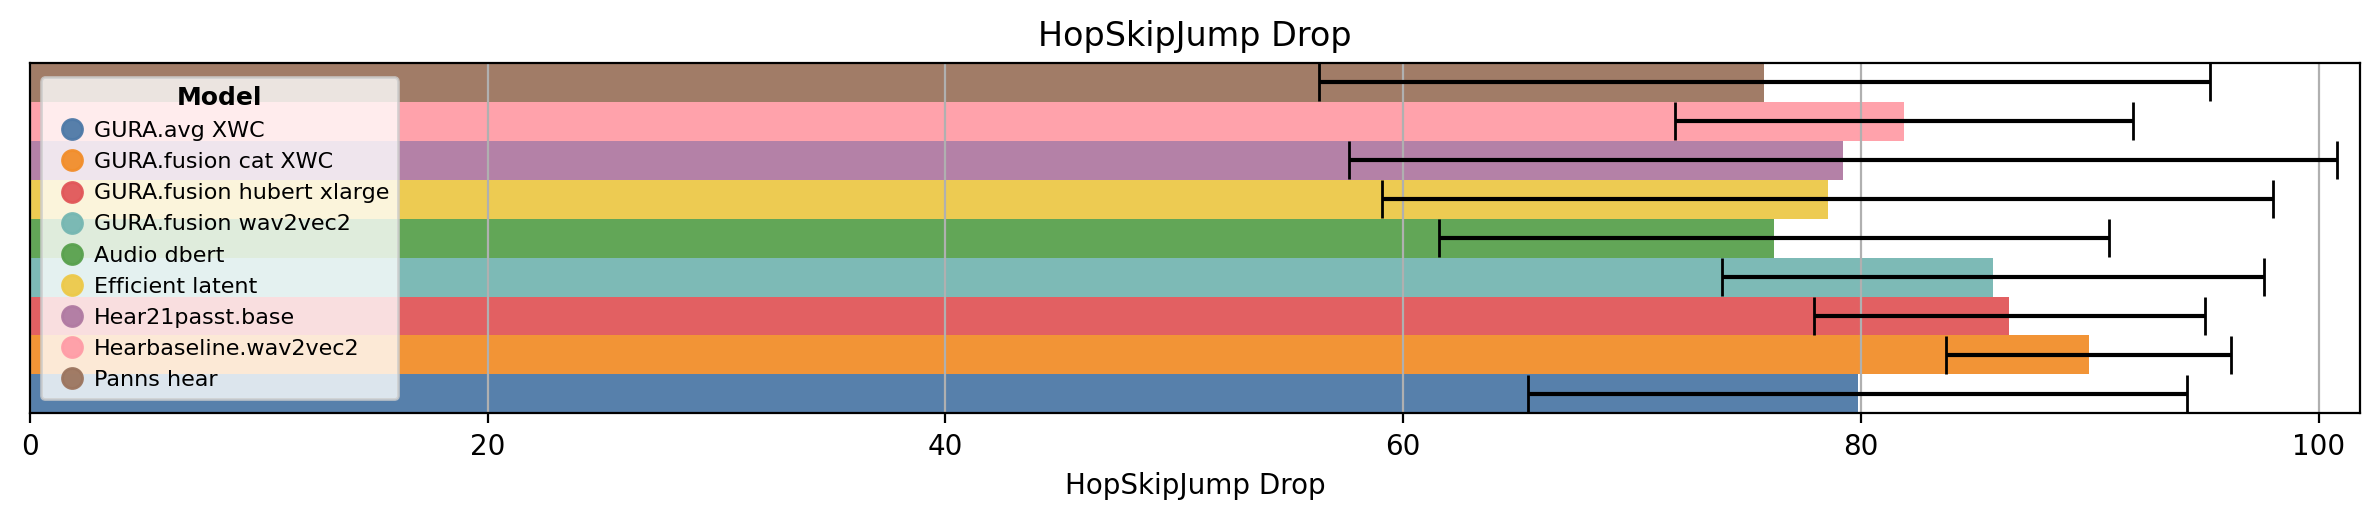

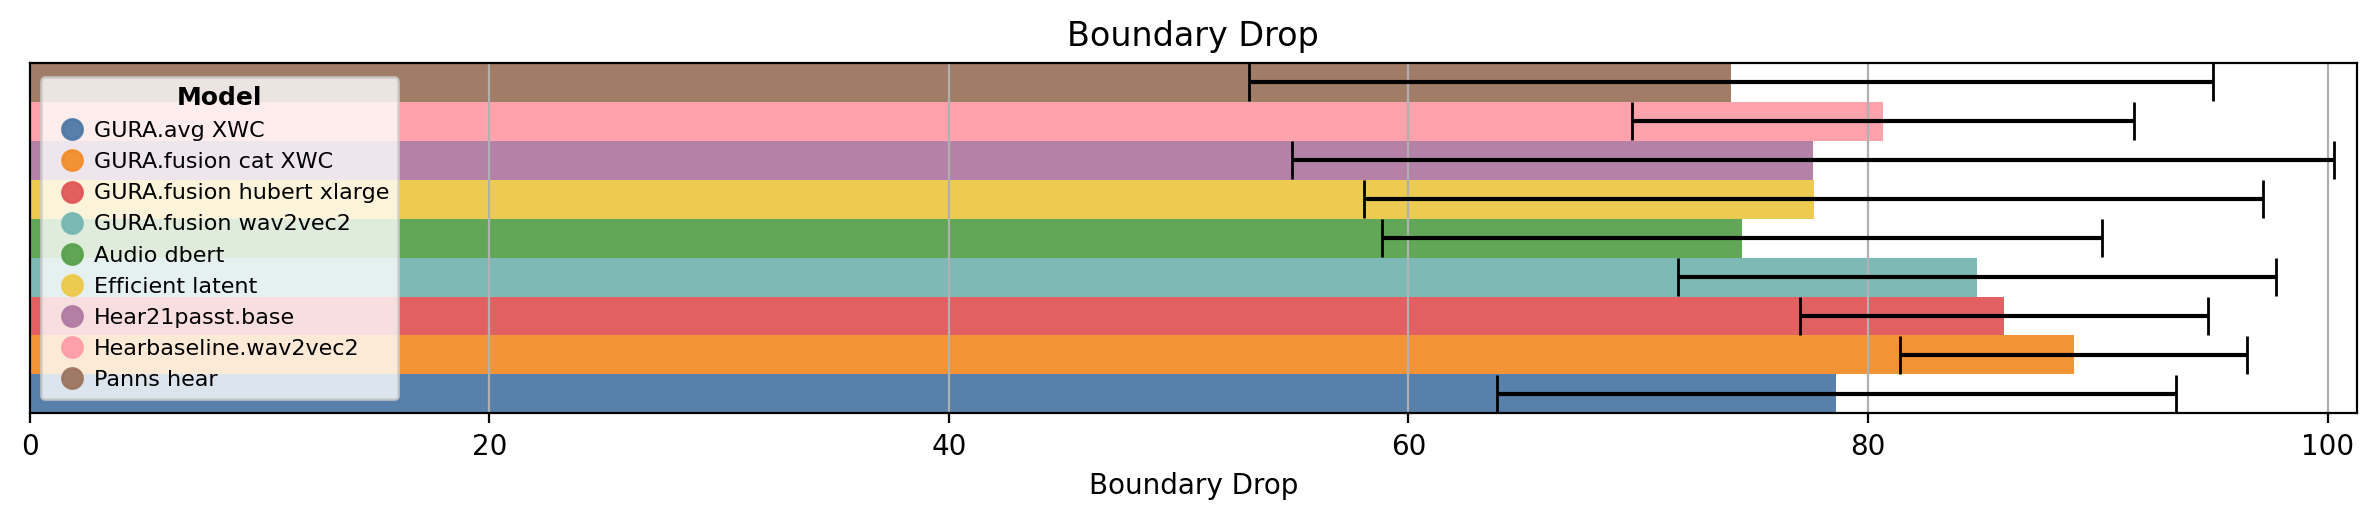

In [26]:
barplots(
    barplot_model_DF,
    groupby=["Model"],
    orientation="horizontal",
    height=12,
    legend_position="center left"
), groupin

In [ ]:
## Pre computed average [No std.dv.]

In [15]:
# Model results x model (%drop in accuracy) [Average]
barplot_model_data = {"Model":[], "Boundary drop":[], "HopSkipJump drop":[]}

for model in model_drop_metrics:
    barplot_model_data["Model"].append(model)
    
    for attack in model_drop_metrics[model]:
        mean_drop = np.mean(np.array(model_drop_metrics[model][attack]))
        print(f"{mean_drop:.5f}  Average % accuracy drop {model} {attack}")

        if attack == "Boundary":
            barplot_model_data["Boundary drop"].append(mean_drop)
        elif attack == "HopSkipJump":
            barplot_model_data["HopSkipJump drop"].append(mean_drop)
            
    print("-"*8)

77.63341  Average % accuracy drop efficient_latent Boundary
78.55243  Average % accuracy drop efficient_latent HopSkipJump
--------
85.92731  Average % accuracy drop GURA.fusion_hubert_xlarge Boundary
86.47770  Average % accuracy drop GURA.fusion_hubert_xlarge HopSkipJump
--------
84.73997  Average % accuracy drop GURA.fusion_wav2vec2 Boundary
85.76565  Average % accuracy drop GURA.fusion_wav2vec2 HopSkipJump
--------
88.95779  Average % accuracy drop GURA.fusion_cat_xwc Boundary
89.94018  Average % accuracy drop GURA.fusion_cat_xwc HopSkipJump
--------
78.62650  Average % accuracy drop GURA.avg_xwc Boundary
79.85097  Average % accuracy drop GURA.avg_xwc HopSkipJump
--------
77.60465  Average % accuracy drop hear21passt.base Boundary
79.20828  Average % accuracy drop hear21passt.base HopSkipJump
--------
80.64423  Average % accuracy drop hearbaseline.wav2vec2 Boundary
81.86276  Average % accuracy drop hearbaseline.wav2vec2 HopSkipJump
--------
74.52952  Average % accuracy drop audio_db

In [16]:
from barplots import barplots
import pandas as pd

barplot_model_DF = pd.DataFrame(barplot_model_data)
barplot_model_DF

,Model,Boundary drop,HopSkipJump drop
0,efficient_latent,77.633406,78.552431
1,GURA.fusion_hubert_xlarge,85.927310,86.477703
2,GURA.fusion_wav2vec2,84.739965,85.765650
3,GURA.fusion_cat_xwc,88.957791,89.940185
4,GURA.avg_xwc,78.626504,79.850971
5,hear21passt.base,77.604653,79.208279
6,hearbaseline.wav2vec2,80.644227,81.862761
7,audio_dbert,74.529522,76.197997
8,panns_hear,74.043396,75.765838


[(<Figure size 2400x540 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'HopSkipJump drop'}, xlabel='HopSkipJump drop'>],
        dtype=object)),
 (<Figure size 2400x540 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'Boundary drop'}, xlabel='Boundary drop'>],
        dtype=object))]

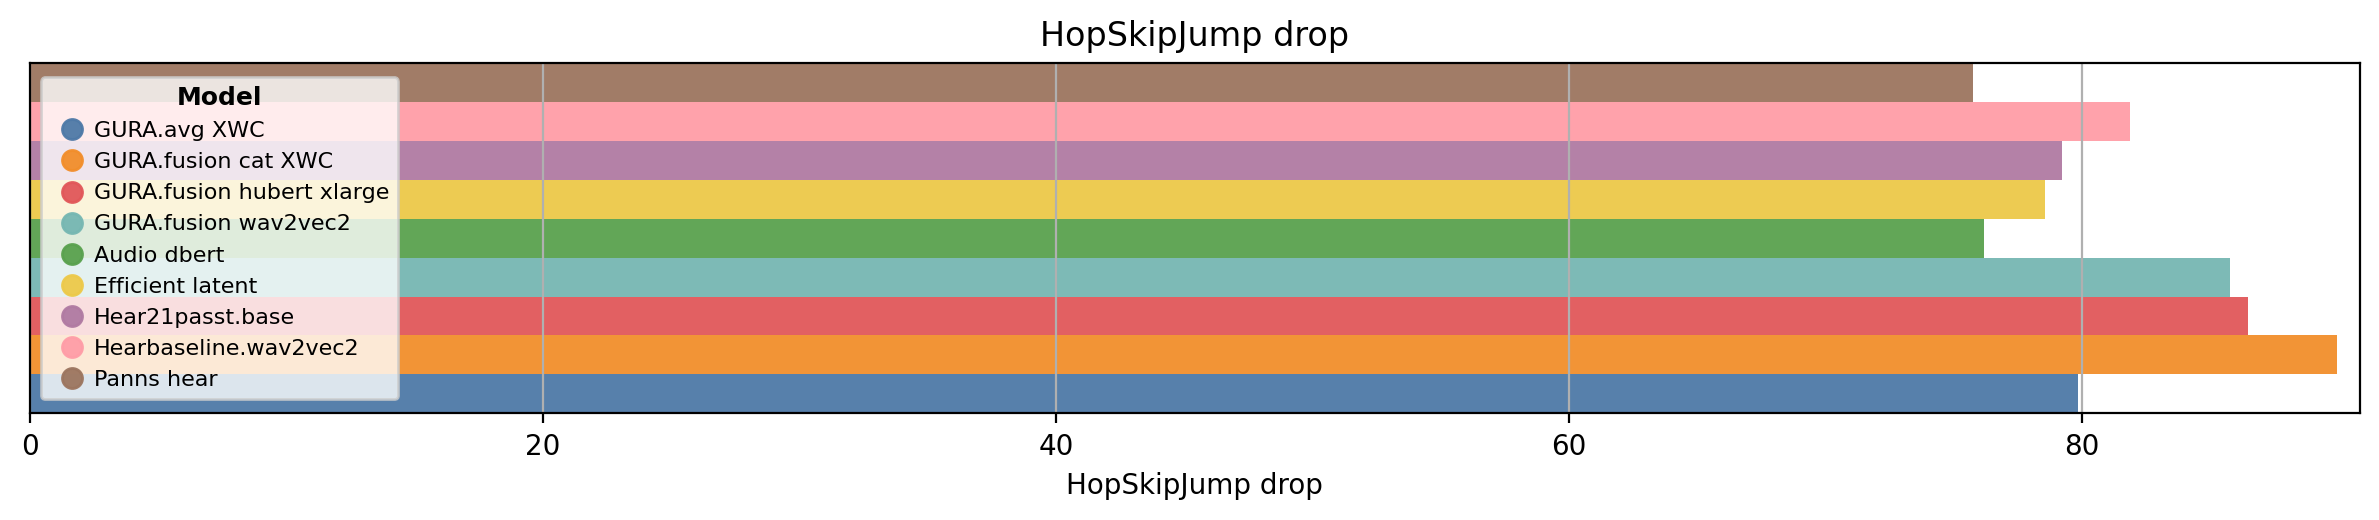

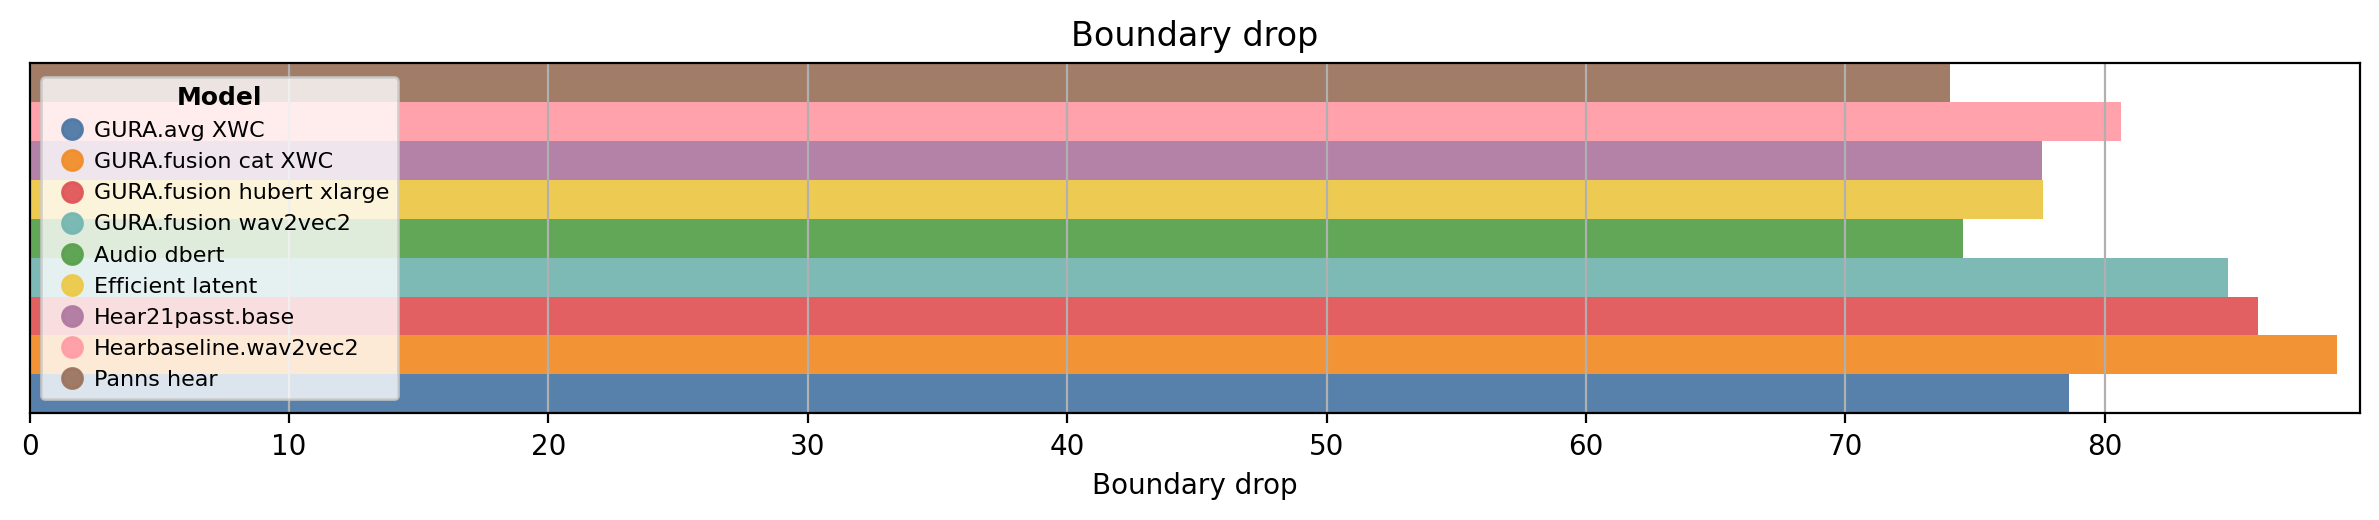

In [17]:
barplots(
    barplot_model_DF,
    groupby=["Model"],
    orientation="horizontal",
    height=12,
    legend_position="center left"
)

In [ ]:
### Notes
## Boundary vs HopSkipJump

## Models <-> Architecture
# *efficient latent* and *paans hear* rely on CNN architecture  +  *audio dbert* combines CNN and transformers.
# *hear21passt.base* relies on transformers.
# *Gura* models ensamble CREPE, Wav2vec, Hubert. Larger models.

#### Note on embeddings
Compute min, max, average and standard deviation of embedding values

In [34]:
with open('datasets.json', 'r') as file:
    datasets = json.load(file)
tasks_name = []
for task in datasets:
    tasks_name.append(task["name"])

models_name = ["efficient_latent", "GURA.fusion_hubert_xlarge", "GURA.fusion_wav2vec2", "GURA.fusion_cat_xwc", "GURA.avg_xwc", "hear21passt.base", "hearbaseline.wav2vec2", "audio_dbert", "panns_hear"]


embedding_metrics = {"Model":[], "mean":[], "std_dv":[], "min":[], "max":[]}

for model_name in models_name:
    embedding_metrics["Model"].append(model_name)
    
    averages = []
    std_deviations = []
    minimums = []
    maximums = []
    
    for task_name in tasks_name:
        # Get task metadata
        embeddings_path = f"embeddings/{model_name}/{task_name}"
        metadata_path = f"{embeddings_path}/task_metadata.json"
        
        with open(metadata_path, 'r') as file:
            metadata = json.load(file)

        if metadata["split_mode"] == "new_split_kfold" or metadata["split_mode"] == "presplit_kfold":
            split = "folds"
            n_folds = metadata["nfolds"]
        elif metadata["split_mode"] == "trainvaltest":
            split = "TVT"
            n_folds = None
        
        # Get embeddings (alphabetical order like labels in .json)
        print("\n-- Retrieving embeddings --")
        embeddings = get_embeddings(embeddings_path, split, n_folds)

        # Compute representation metrics
        for emb in embeddings.values():
            avg = np.mean(emb)
            std_dv = np.std(emb)
            min = np.min(emb)
            max = np.max(emb)
        
            averages.append(avg)
            std_deviations.append(std_dv)
            minimums.append(min)
            maximums.append(max)
        
    # Compute overall model embeddings metrics
    model_avg = np.mean(averages)
    model_std_dv = np.mean(std_deviations)
    model_min = np.min(minimums)
    model_max = np.max(maximums)

    print("\n")
    print(f"Model {model_name} emb Average: {model_avg}")
    print(f"Model {model_name} emb Standard Deviation: {model_std_dv}")
    print(f"Model {model_name} emb Minimum: {model_min}")
    print(f"Model {model_name} emb Maximum: {model_max}")
    print("-"*40)

    embedding_metrics["mean"].append(model_avg)
    embedding_metrics["std_dv"].append(model_std_dv)
    embedding_metrics["min"].append(model_min)
    embedding_metrics["max"].append(model_max)


-- Retrieving embeddings --
stored in fold00 embeddings embeddings/efficient_latent/beijing_opera/fold00
stored in fold01 embeddings embeddings/efficient_latent/beijing_opera/fold01
stored in fold02 embeddings embeddings/efficient_latent/beijing_opera/fold02
stored in fold03 embeddings embeddings/efficient_latent/beijing_opera/fold03
stored in fold04 embeddings embeddings/efficient_latent/beijing_opera/fold04

-- Retrieving embeddings --
stored in fold00 embeddings embeddings/efficient_latent/esc50/fold00
stored in fold01 embeddings embeddings/efficient_latent/esc50/fold01
stored in fold02 embeddings embeddings/efficient_latent/esc50/fold02
stored in fold03 embeddings embeddings/efficient_latent/esc50/fold03
stored in fold04 embeddings embeddings/efficient_latent/esc50/fold04

-- Retrieving embeddings --
stored in fold00 embeddings embeddings/efficient_latent/gunshot/fold00
stored in fold01 embeddings embeddings/efficient_latent/gunshot/fold01
stored in fold02 embeddings embeddings/ef

In [37]:
import pandas as pd

barplot_embMetrics_DF = pd.DataFrame(embedding_metrics)
barplot_embMetrics_DF

,Model,mean,std_dv,min,max
0,efficient_latent,0.089369,0.202767,-0.271522,12.294580
1,GURA.fusion_hubert_xlarge,1.268005,11.951848,-127.111580,621.489624
2,GURA.fusion_wav2vec2,2.324272,10.243121,-133.174515,260.444824
3,GURA.fusion_cat_xwc,1.226983,7.934299,-133.174515,385.885742
4,GURA.avg_xwc,0.025933,0.173447,-2.143196,3.606036
5,hear21passt.base,-3.388269,4.351589,-21.600815,19.807819
6,hearbaseline.wav2vec2,0.000388,0.054910,-1.028935,1.221428
7,audio_dbert,-0.000318,0.827282,-10.535548,15.570044
8,panns_hear,0.084876,0.230684,0.000000,14.402995


In [ ]:
### Notes
## Abs values
# 3 worst *Gura* -> high abs values, *Gura avg* better
# Panns hear best results -> (0,max)
# BUT baseline.wav2vec VS hear21passt.base

#### Per Task
Model results per task (% drop in accuracy)

In [34]:
#To compute average/plot
task_metrics = {}
for task in tasks_name:
    task_metrics[task] = {} 
    for model in results:
        for attack in results[model][task]:
            if attack != "clean":
                task_metrics[task][attack] = []

task_results = {}
for task in tasks_name:
    task_results[task] = {}
    print(task)
    print("-"*20)
    for model in results:
        task_results[task][model] = {}
        print(model)
        for attack in results[model][task]:
            if attack != "clean":
                drop = calculate_drop(results[model][task]['clean'][0], results[model][task][attack][0])
                
                print(f"({results[model][task]['clean'][0]:.5f} -> {results[model][task][attack][0]:.5f}) {drop:.5f}   % drop with attack {attack}")
        
                task_results[task][model][attack] = []
                task_results[task][model][attack].append(drop)
                
                task_metrics[task][attack].append(drop)
        print("-"*8)
    print("")

beijing_opera
--------------------
efficient_latent
(0.94486 -> 0.13963) 85.22236   % drop with attack Boundary
(0.94486 -> 0.13963) 85.22237   % drop with attack HopSkipJump
--------
GURA.fusion_hubert_xlarge
(0.94504 -> 0.11028) 88.33021   % drop with attack Boundary
(0.94504 -> 0.11028) 88.33021   % drop with attack HopSkipJump
--------
GURA.fusion_wav2vec2
(0.93635 -> 0.05098) 94.55595   % drop with attack Boundary
(0.93635 -> 0.05098) 94.55595   % drop with attack HopSkipJump
--------
GURA.fusion_cat_xwc
(0.95328 -> 0.03821) 95.99182   % drop with attack Boundary
(0.95328 -> 0.03395) 96.43821   % drop with attack HopSkipJump
--------
GURA.avg_xwc
(0.92784 -> 0.05940) 93.59832   % drop with attack Boundary
(0.92784 -> 0.05940) 93.59832   % drop with attack HopSkipJump
--------
hear21passt.base
(0.95363 -> 0.04211) 95.58427   % drop with attack Boundary
(0.95363 -> 0.03794) 96.02120   % drop with attack HopSkipJump
--------
hearbaseline.wav2vec2
(0.91489 -> 0.07660) 91.62791   % dro

In [44]:
barplot_tasks = []
barplot_drop_B = []
barplot_drop_H = []

# Extract data for barplot
for task, models in task_metrics.items():
    for attack, metrics in models.items():
        if attack == "Boundary":
            barplot_tasks.extend([task] * len(metrics))
            barplot_drop_B.extend([item for item in metrics])
        elif attack == "HopSkipJump":
            barplot_drop_H.extend([item for item in metrics])

# Format as DataFrame
barplot_task_DF = pd.DataFrame({
    'Task': barplot_tasks,
    'Boundary Drop': barplot_drop_B,
    'HopSkipJump Drop': barplot_drop_H,
})

print(barplot_task_DF)

              Task  Boundary Drop  HopSkipJump Drop
0    beijing_opera      85.222363         85.222369
1    beijing_opera      88.330209         88.330209
2    beijing_opera      94.555950         94.555950
3    beijing_opera      95.991820         96.438205
4    beijing_opera      93.598318         93.598318
..             ...            ...               ...
103        crema-D      59.084260         60.585248
104        crema-D      65.873408         66.785276
105        crema-D      73.610270         73.649877
106        crema-D      55.859458         59.331286
107        crema-D      60.782695         63.780951

[108 rows x 3 columns]


[(<Figure size 2400x720 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'HopSkipJump Drop'}, xlabel='HopSkipJump Drop'>],
        dtype=object)),
 (<Figure size 2400x720 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'Boundary Drop'}, xlabel='Boundary Drop'>],
        dtype=object))]

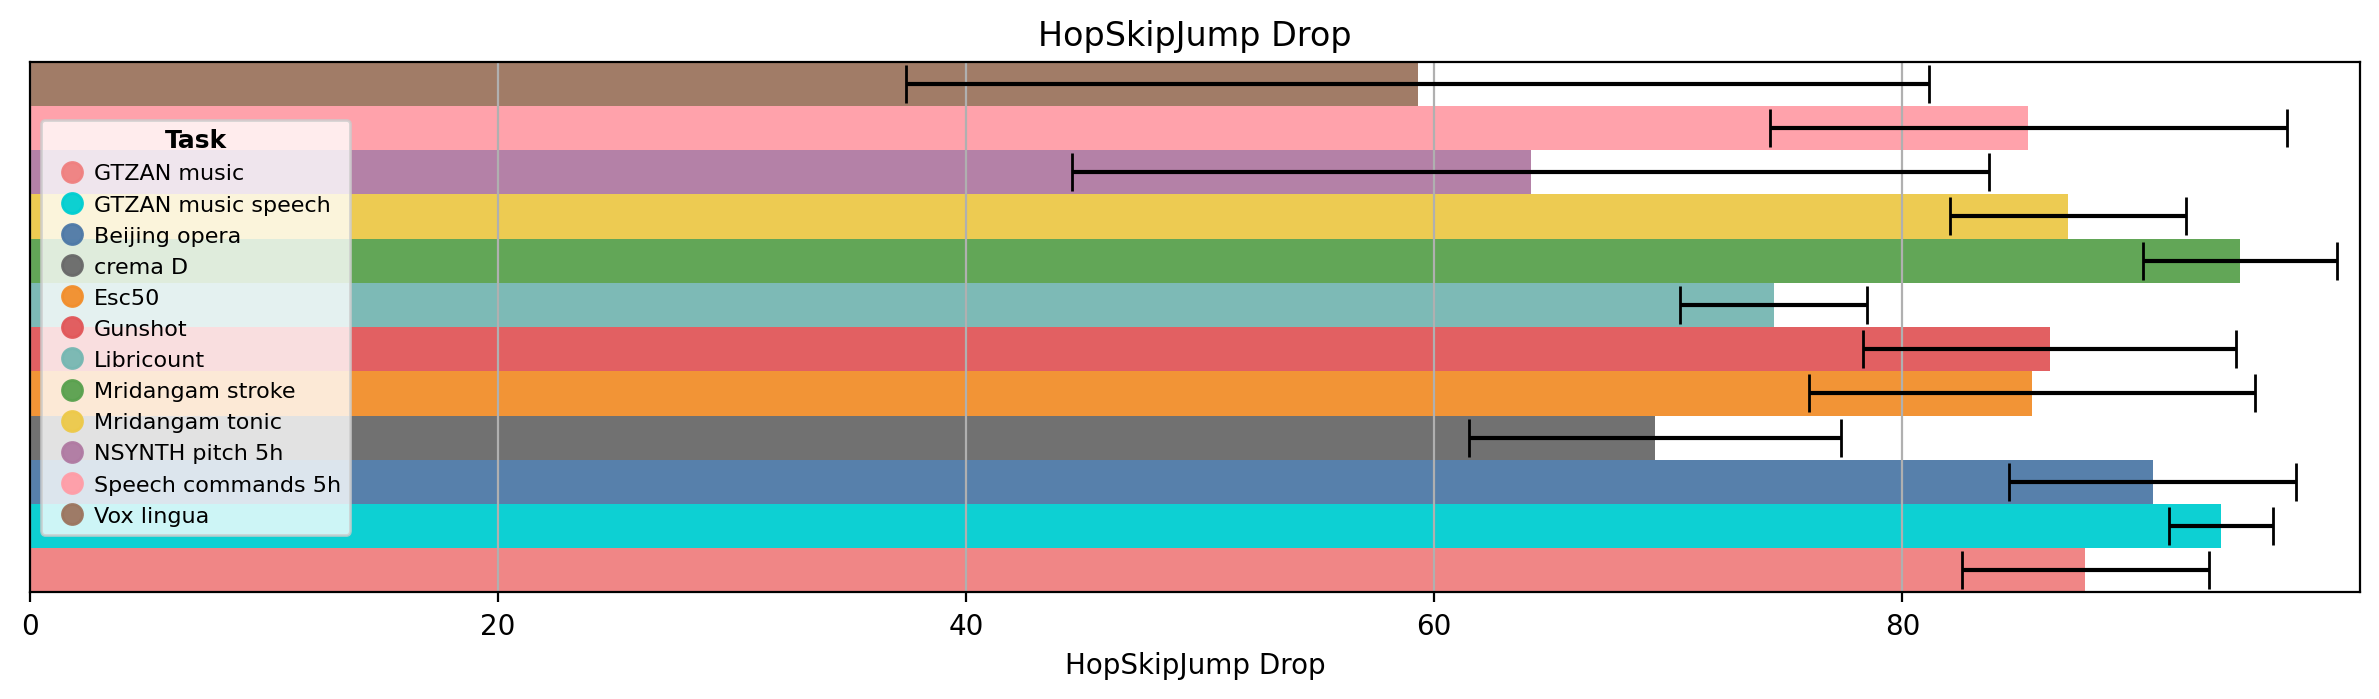

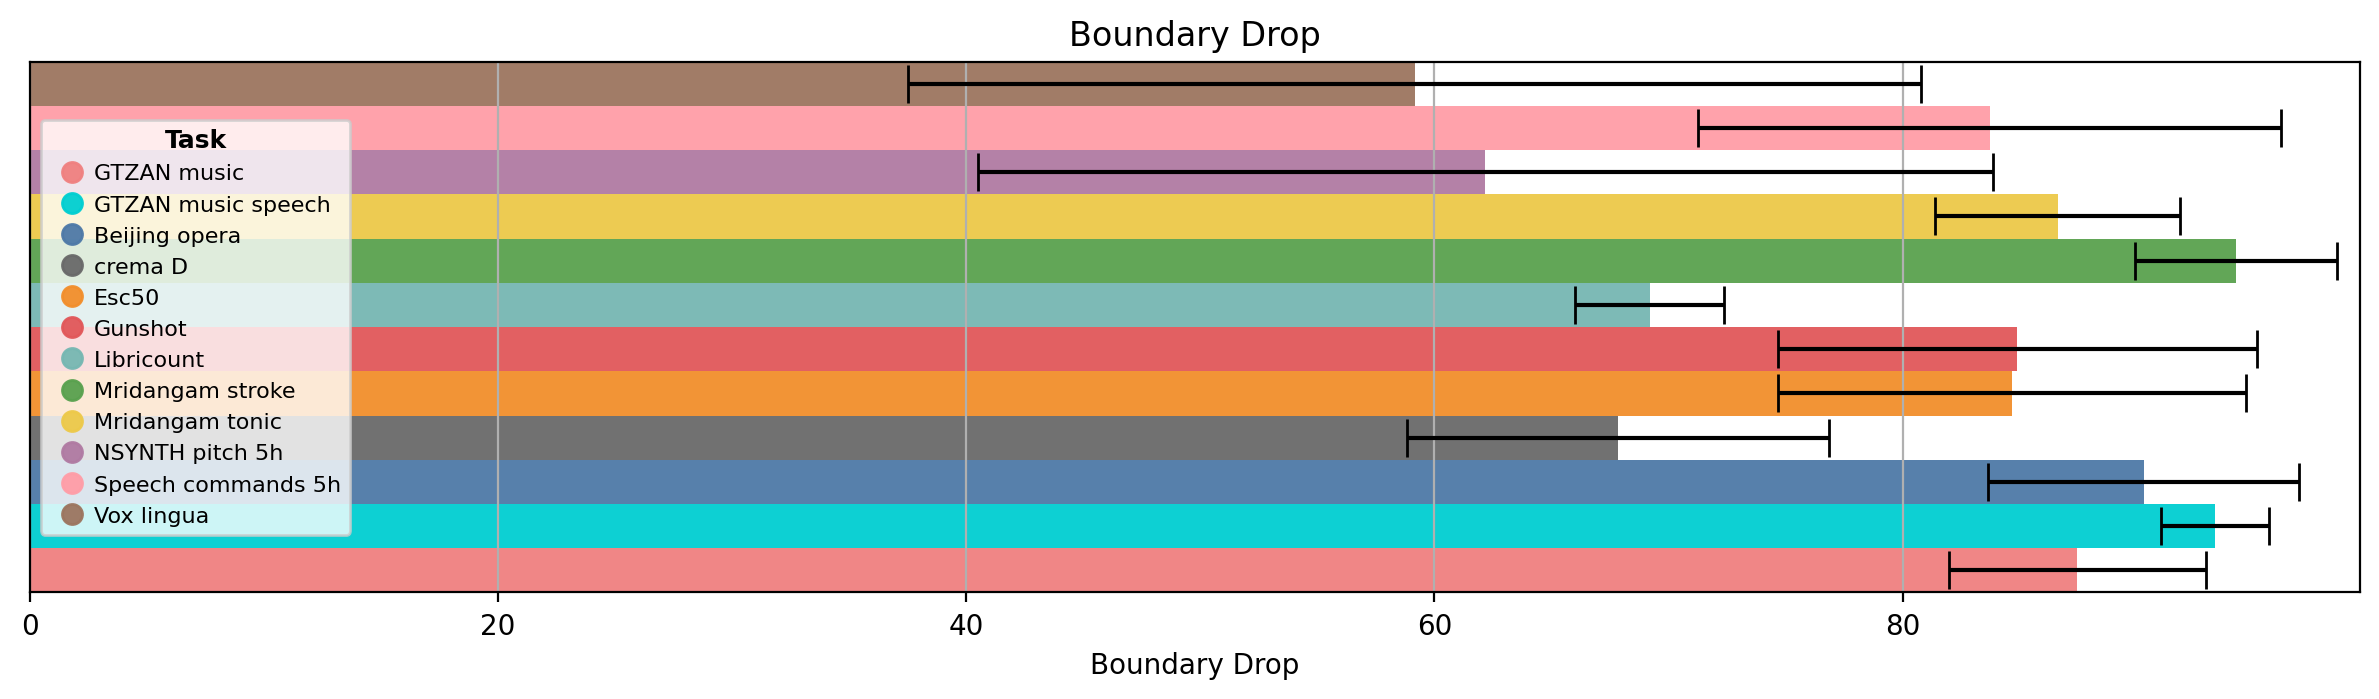

In [46]:
TASK_COLORS = [
    '#4e79a7',
    '#f28e2b',
    '#e15759',
    '#76b7b2',
    '#59a14e',
    "#edc949",
    "#b07aa2",
    "#ff9da7",
    "#9c755f",
    'lightcoral',
    'darkturquoise',
    'dimgrey'
]

barplots(
    barplot_task_DF,
    groupby=["Task"],
    orientation="horizontal",
    height=12,
    legend_position="center left",
    colors={
        'beijing_opera':TASK_COLORS[0],
        'esc50':TASK_COLORS[1],
        'gunshot':TASK_COLORS[2],
        'libricount':TASK_COLORS[3],
        'mridangam_stroke':TASK_COLORS[4],
        'mridangam_tonic':TASK_COLORS[5],
        'nsynth_pitch_5h':TASK_COLORS[6],
        'speech_commands_5h':TASK_COLORS[7],
        'vox_lingua':TASK_COLORS[8],
        'GTZAN_music':TASK_COLORS[9],
        'GTZAN_music_speech': TASK_COLORS[10],
        'crema-D': TASK_COLORS[11]
    }
)

In [ ]:
## Pre computed average [No std.dv.]

In [51]:
# Model results x task (%drop in accuracy) [Average]
barplot_task_data = {"Task":[], "Boundary drop":[], "HopSkipJump drop":[]}

for task in task_metrics:
    barplot_task_data["Task"].append(task)
    
    for attack in task_metrics[task]:
        mean_drop = np.mean(np.array(task_metrics[task][attack]))
        print(f"{mean_drop:.5f}  Average % accuracy drop {task} {attack}")

        if attack == "Boundary":
            barplot_task_data["Boundary drop"].append(mean_drop)
        elif attack == "HopSkipJump":
            barplot_task_data["HopSkipJump drop"].append(mean_drop)
            
    print("-"*8)

90.29482  Average % accuracy drop beijing_opera Boundary
90.69763  Average % accuracy drop beijing_opera HopSkipJump
--------
84.67017  Average % accuracy drop esc50 Boundary
85.53605  Average % accuracy drop esc50 HopSkipJump
--------
84.89236  Average % accuracy drop gunshot Boundary
86.28886  Average % accuracy drop gunshot HopSkipJump
--------
69.18840  Average % accuracy drop libricount Boundary
74.50063  Average % accuracy drop libricount HopSkipJump
--------
94.24016  Average % accuracy drop mridangam_stroke Boundary
94.43159  Average % accuracy drop mridangam_stroke HopSkipJump
--------
86.63057  Average % accuracy drop mridangam_tonic Boundary
87.08112  Average % accuracy drop mridangam_tonic HopSkipJump
--------
62.17596  Average % accuracy drop nsynth_pitch_5h Boundary
64.12137  Average % accuracy drop nsynth_pitch_5h HopSkipJump
--------
83.72272  Average % accuracy drop speech_commands_5h Boundary
85.37466  Average % accuracy drop speech_commands_5h HopSkipJump
--------
59

In [52]:
barplot_task_DF = pd.DataFrame(barplot_task_data)
barplot_task_DF

,Task,Boundary drop,HopSkipJump drop
0,beijing_opera,90.294825,90.697630
1,esc50,84.670167,85.536052
2,gunshot,84.892361,86.288860
3,libricount,69.188401,74.500628
4,mridangam_stroke,94.240163,94.431590
5,mridangam_tonic,86.630572,87.081122
6,nsynth_pitch_5h,62.175962,64.121370
7,speech_commands_5h,83.722715,85.374665
8,vox_lingua,59.157596,59.289234
9,GTZAN_music,87.460332,87.809805



Rendering barplots: 100%|████████████████████████████████████████| 2/2 [00:00<00:00,  3.60it/s]
                                                                                               

[(<Figure size 2400x720 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'Boundary drop'}, xlabel='Boundary drop'>],
        dtype=object)),
 (<Figure size 2400x720 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'HopSkipJump drop'}, xlabel='HopSkipJump drop'>],
        dtype=object))]

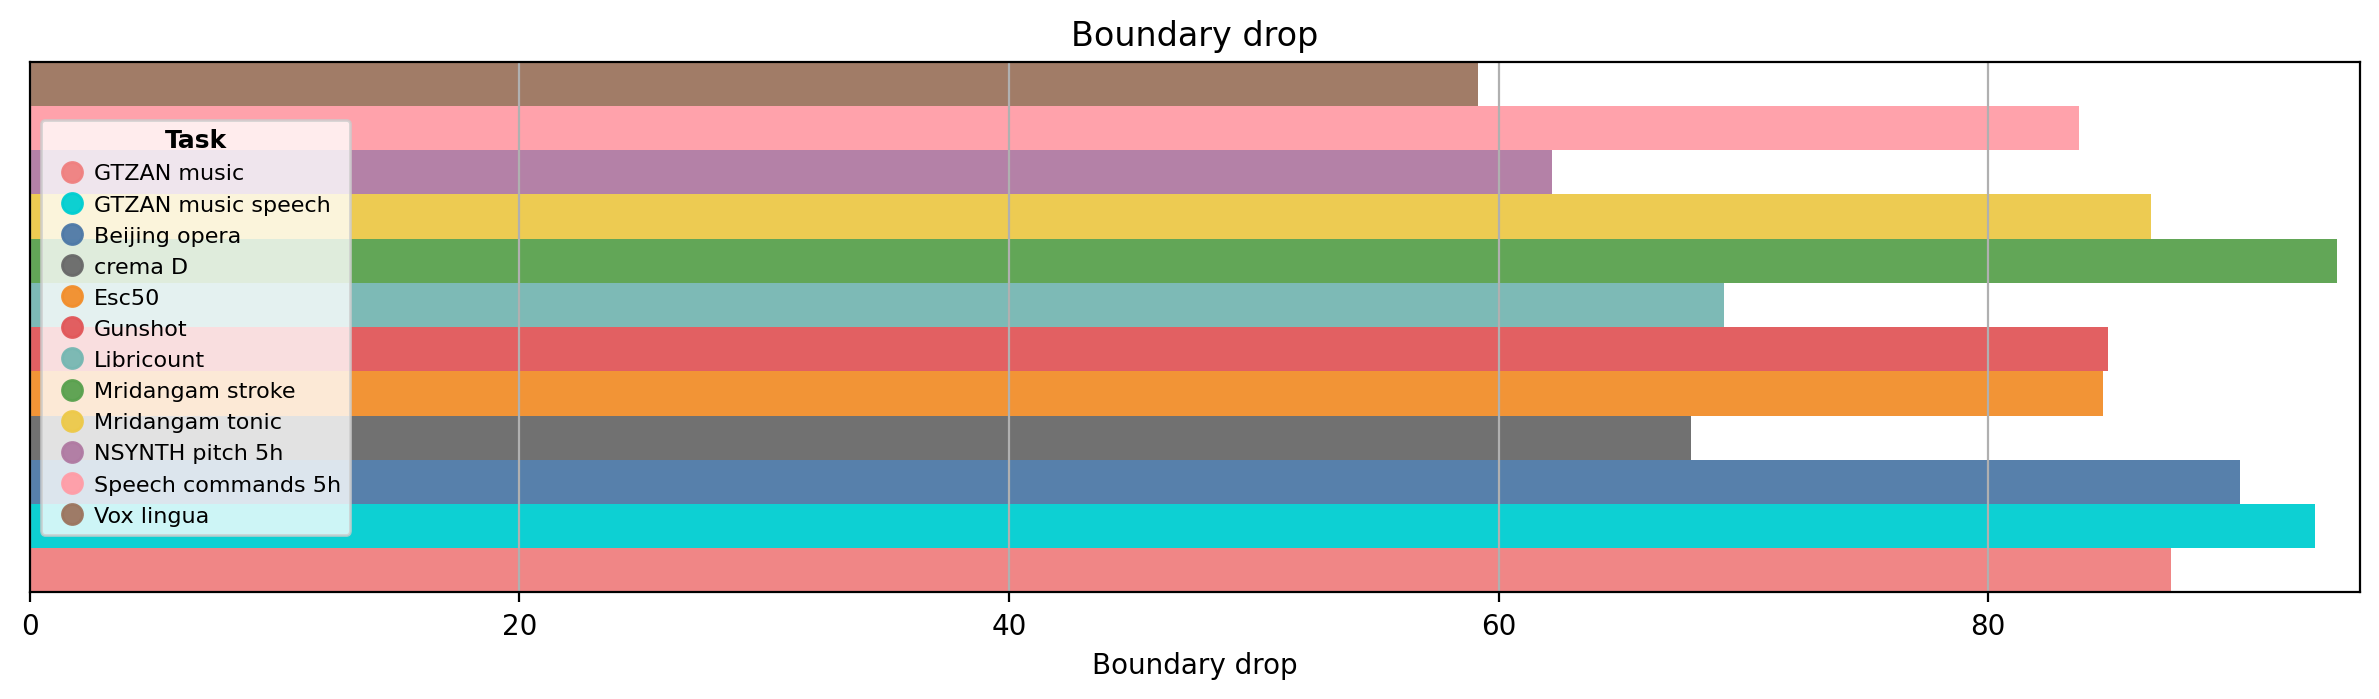

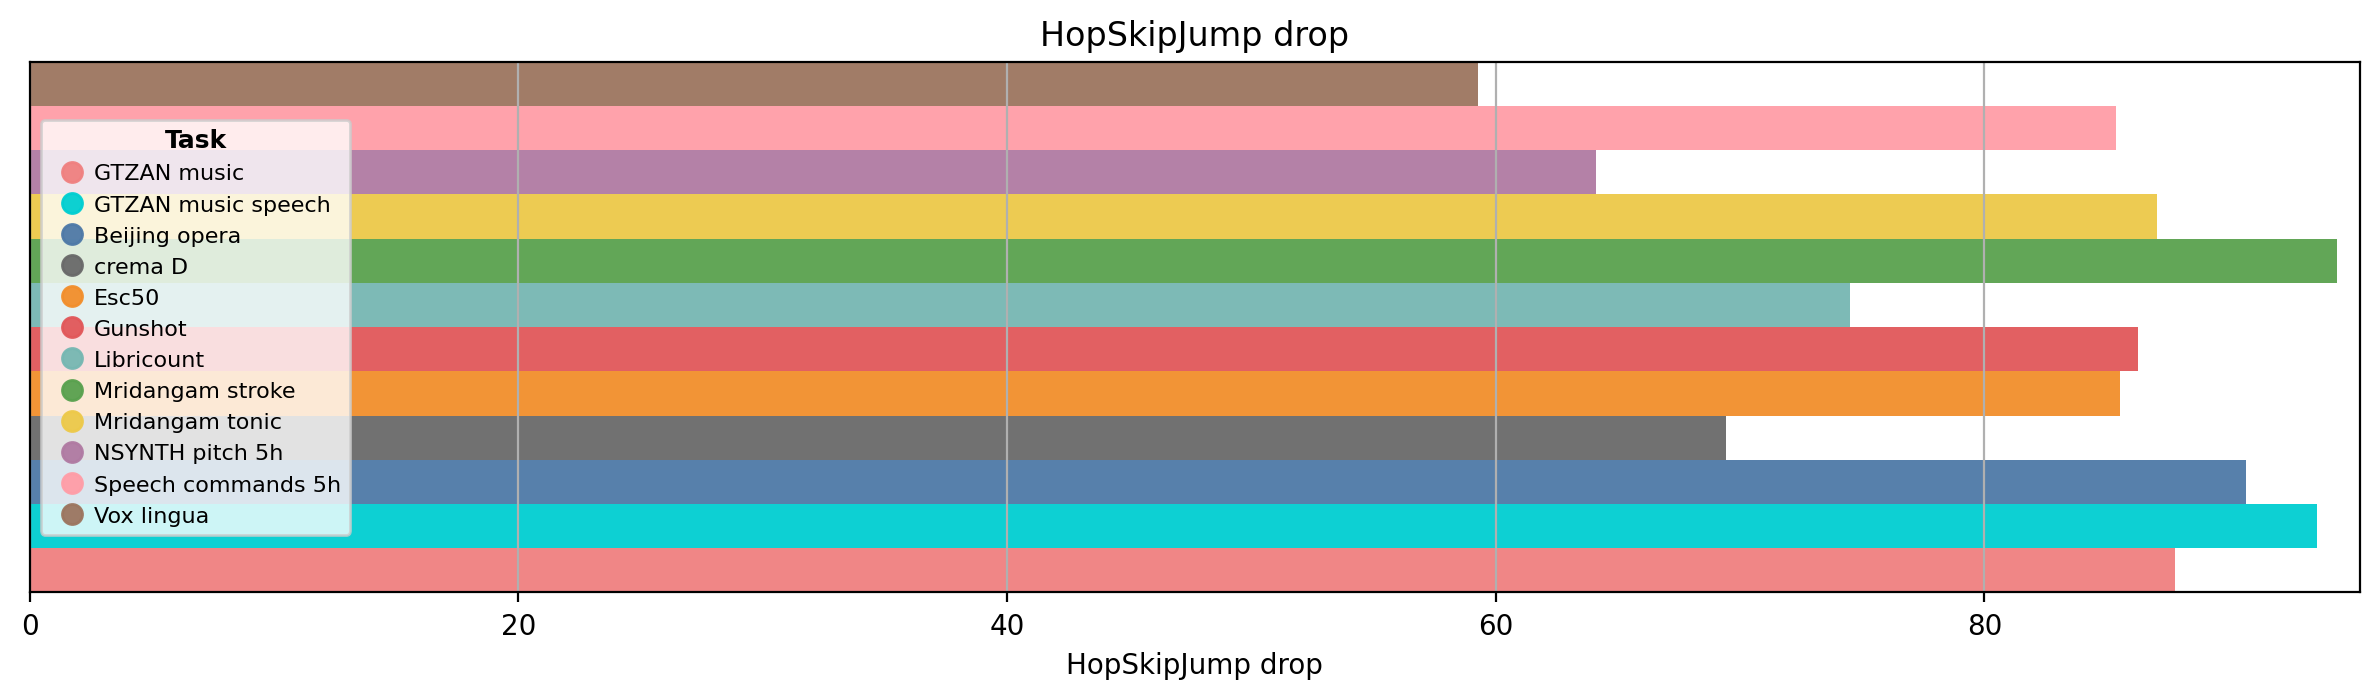

In [27]:
TASK_COLORS = [
    '#4e79a7',
    '#f28e2b',
    '#e15759',
    '#76b7b2',
    '#59a14e',
    "#edc949",
    "#b07aa2",
    "#ff9da7",
    "#9c755f",
    'lightcoral',
    'darkturquoise',
    'dimgrey'
]

barplots(
    barplot_task_DF,
    groupby=["Task"],
    orientation="horizontal",
    height=12,
    legend_position="center left",
    colors={
        'beijing_opera':TASK_COLORS[0],
        'esc50':TASK_COLORS[1],
        'gunshot':TASK_COLORS[2],
        'libricount':TASK_COLORS[3],
        'mridangam_stroke':TASK_COLORS[4],
        'mridangam_tonic':TASK_COLORS[5],
        'nsynth_pitch_5h':TASK_COLORS[6],
        'speech_commands_5h':TASK_COLORS[7],
        'vox_lingua':TASK_COLORS[8],
        'GTZAN_music':TASK_COLORS[9],
        'GTZAN_music_speech': TASK_COLORS[10],
        'crema-D': TASK_COLORS[11]
    }
)

In [ ]:
### Notes
# Better handled tasks
# Model resiliance still stands out, see speech_commands_5h on efficient_latent

#### Distance metrics

In [47]:
# Distance metrics x task  #Correctly -> not too different, no correlation with task results.
for task in tasks_name:
    print(task)
    for model in distance:
        for attack in distance[model][task]:
            for metric in distance[model][task][attack]:
                print(f"{distance[model][task][attack][metric][0]:.5f}   {metric} metric for attack {attack}")
        print("-")

    print("")

beijing_opera
0.45586   Wilcoxon metric for attack Boundary
0.52275   Euclidean metric for attack Boundary
0.42426   Wilcoxon metric for attack HopSkipJump
0.50106   Euclidean metric for attack HopSkipJump
-
0.69301   Wilcoxon metric for attack Boundary
0.10950   Euclidean metric for attack Boundary
0.64848   Wilcoxon metric for attack HopSkipJump
0.07484   Euclidean metric for attack HopSkipJump
-
0.77470   Wilcoxon metric for attack Boundary
0.04306   Euclidean metric for attack Boundary
0.75703   Wilcoxon metric for attack HopSkipJump
0.03472   Euclidean metric for attack HopSkipJump
-
0.61665   Wilcoxon metric for attack Boundary
0.12868   Euclidean metric for attack Boundary
0.59202   Wilcoxon metric for attack HopSkipJump
0.09758   Euclidean metric for attack HopSkipJump
-
0.63553   Wilcoxon metric for attack Boundary
0.34765   Euclidean metric for attack Boundary
0.61365   Wilcoxon metric for attack HopSkipJump
0.37618   Euclidean metric for attack HopSkipJump
-
0.74954   Wilcox

In [48]:
# Distance metrics x task [Average]
task_p_values = {}
task_euclideans = {}

for task in tasks_name:
    task_p_values[task] = []
    task_euclideans[task] = []

for model in distance:
    for task in distance[model]:
        for attack in distance[model][task]:
            task_p_values[task].append(distance[model][task][attack]["Wilcoxon"][0])
            task_euclideans[task].append(distance[model][task][attack]["Euclidean"][0]) 

In [49]:
for task in task_p_values:
    print(f"Average p_value across all models for task {task}: {np.mean(np.array(task_p_values[task])):.5f}")
print("-"*20)
for task in task_euclideans:
    print(f"Average euclidean distances across all models for task {task}: {np.mean(np.array(task_euclideans[task])):.5f}")

Average p_value across all models for task beijing_opera: 0.58736
Average p_value across all models for task esc50: 0.61500
Average p_value across all models for task gunshot: 0.65040
Average p_value across all models for task libricount: 0.40204
Average p_value across all models for task mridangam_stroke: 0.59714
Average p_value across all models for task mridangam_tonic: 0.64257
Average p_value across all models for task nsynth_pitch_5h: 0.72351
Average p_value across all models for task speech_commands_5h: 0.45980
Average p_value across all models for task vox_lingua: 0.77829
Average p_value across all models for task GTZAN_music: 0.64305
Average p_value across all models for task GTZAN_music_speech: 0.61243
Average p_value across all models for task crema-D: 0.73953
--------------------
Average euclidean distances across all models for task beijing_opera: 0.21156
Average euclidean distances across all models for task esc50: 0.16164
Average euclidean distances across all models for 

In [50]:
# Distance metrics x model [Average] #Correctly -> not too different, no correlation with model results.
model_p_values = {}
model_euclideans = {}

for model in distance:
    model_p_values[model] = []
    model_euclideans[model] = []
    for task in distance[model]:
        for attack in distance[model][task]:
            model_p_values[model].append(distance[model][task][attack]["Wilcoxon"][0])
            model_euclideans[model].append(distance[model][task][attack]["Euclidean"][0]) 

In [51]:
for model in model_p_values:
    print(f"Average p_value across all tasks for model {model}: {np.mean(np.array(model_p_values[model])):.5f}")
print("-"*20)
for model in model_euclideans:
    print(f"Average euclidean distances across all tasks for model {model}: {np.mean(np.array(model_euclideans[model])):.5f}")

Average p_value across all tasks for model efficient_latent: 0.59829
Average p_value across all tasks for model GURA.fusion_hubert_xlarge: 0.71407
Average p_value across all tasks for model GURA.fusion_wav2vec2: 0.75911
Average p_value across all tasks for model GURA.fusion_cat_xwc: 0.61237
Average p_value across all tasks for model GURA.avg_xwc: 0.71425
Average p_value across all tasks for model hear21passt.base: 0.74527
Average p_value across all tasks for model hearbaseline.wav2vec2: 0.53281
Average p_value across all tasks for model audio_dbert: 0.80541
Average p_value across all tasks for model panns_hear: 0.10678
--------------------
Average euclidean distances across all tasks for model efficient_latent: 0.24070
Average euclidean distances across all tasks for model GURA.fusion_hubert_xlarge: 0.12263
Average euclidean distances across all tasks for model GURA.fusion_wav2vec2: 0.06182
Average euclidean distances across all tasks for model GURA.fusion_cat_xwc: 0.13874
Average eucl

In [62]:
barplot_models = []
barplot_pvalue = []
barplot_euclidean = []

# Extract data for barplot
for model, tasks in model_p_values.items():
    barplot_models.extend([model] * len(tasks))
    barplot_pvalue.extend([item for item in tasks])

for model, tasks in model_euclideans.items():
    barplot_euclidean.extend([item for item in tasks])

# Format as DataFrame
barplot_distance_DF = pd.DataFrame({
    'Model': barplot_models,
    'P value': barplot_pvalue,
    'Euclidean Distance Normalized': barplot_euclidean,
})

print(barplot_distance_DF)

                Model   P value  Euclidean Distance Normalized
0    efficient_latent  0.455856                       0.522754
1    efficient_latent  0.424263                       0.501061
2    efficient_latent  0.194563                       0.531701
3    efficient_latent  0.257699                       0.484046
4    efficient_latent  0.695212                       0.163561
..                ...       ...                            ...
211        panns_hear  0.054089                       0.480275
212        panns_hear  0.123482                       0.249000
213        panns_hear  0.141678                       0.281527
214        panns_hear  0.138979                       0.041328
215        panns_hear  0.141073                       0.037408

[216 rows x 3 columns]


[(<Figure size 2400x540 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'P value'}, xlabel='P value'>],
        dtype=object)),
 (<Figure size 2400x540 with 1 Axes>,
  array([<AxesSubplot: title={'center': 'Euclidean Distance Normalized'}, xlabel='Euclidean Distance Normalized'>],
        dtype=object))]

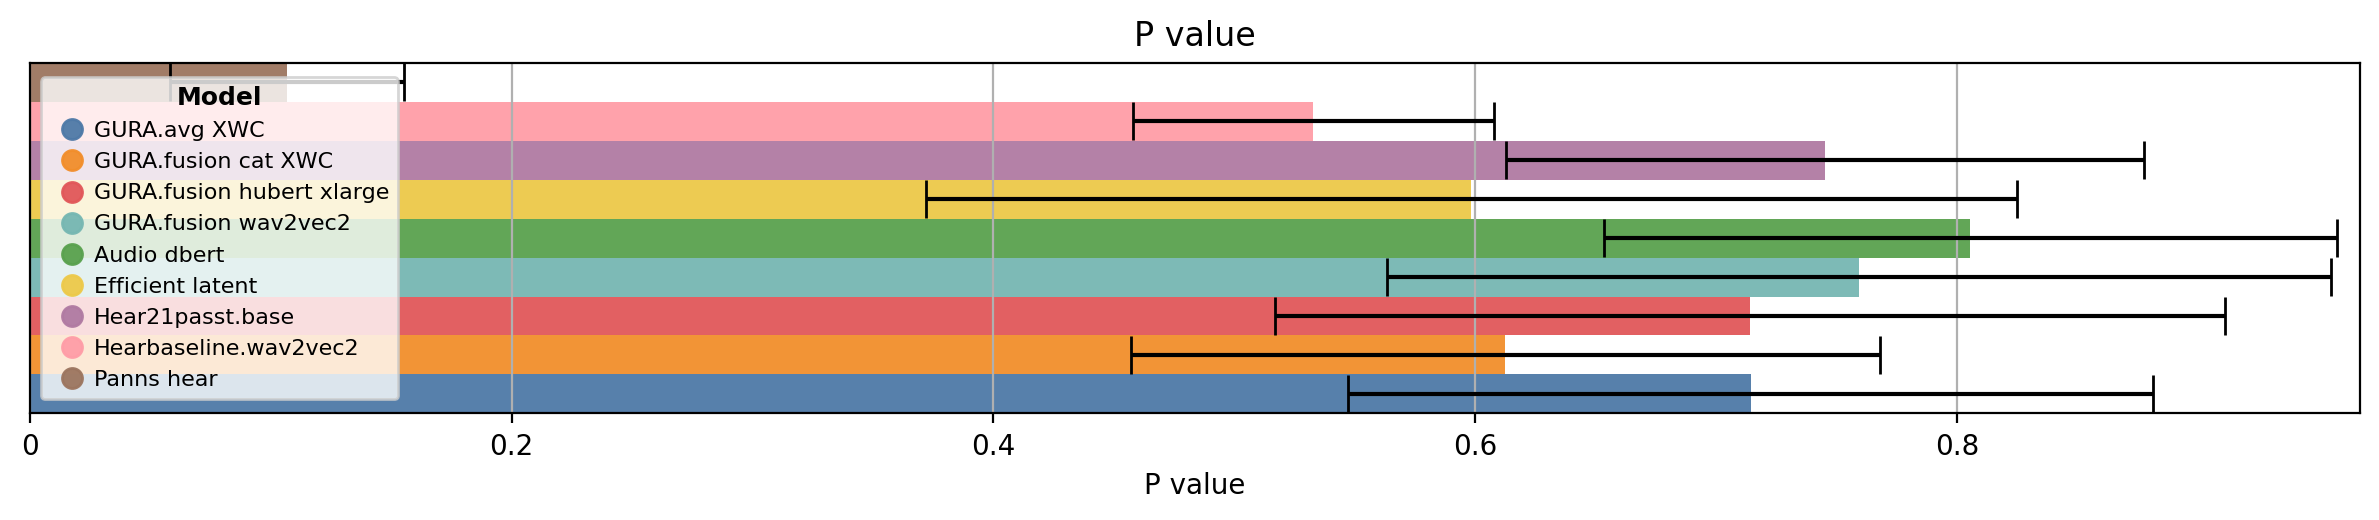

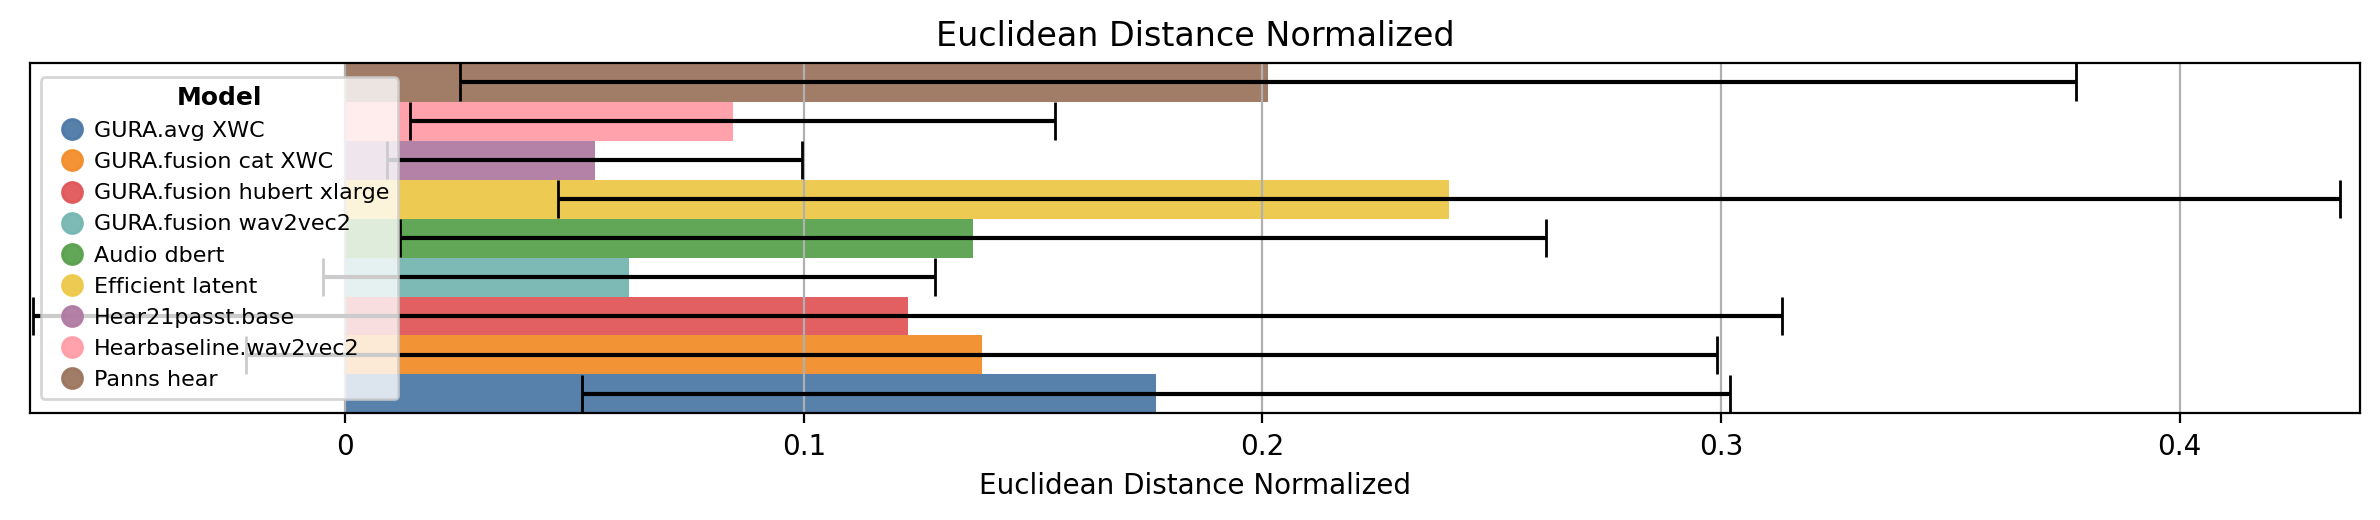

In [65]:
barplots(
    barplot_distance_DF,
    groupby=["Model"],
    orientation="horizontal",
    height=12,
    legend_position="center left"
)

In [ ]:
### Notes
# Low distances
# No correlation with performances